# Classification: Predicting Diabetes Based on Modifiable Factors

(max 2000 written words, not including citations)

# Introduction

- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question

**Research question:**
Can the 5 following modifiable/reversible factors predict the onset of diabetes within 5 years with a high degree of accuracy (>75%)?
1. Plasma glucose concentration level at 2 hours in an oral glucose tolerance test (ie. glucose test, mg/dl)
2. Diastolic blood pressure (mmHg)
3. Triceps skin fold thickness - a measure of body fat (mm)
4. 2-Hour serum insulin (µU/mL)
5. Body mass index (kg/m^2)

# Methods

- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.

# Analysis

- loads data from the original source on the web 
- wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
- performs the data analysis

In [7]:
#installation packages commented out for convenience.

#install.packages("tidyverse")
#install.packages("tidymodels")
#install.packages("gridExtra")
#install.packages("repr")
#install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
#setting seed and loading necessary libraries
set.seed(1000)
library("tidyverse")
library("tidymodels")
library("repr")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [4]:
#loading data and tidying 
diabetes_dataset <- read_csv("https://raw.githubusercontent.com/hesoru/DSCI_100_Diabetes_Prediction/main/Dataset/diabetes.csv")

diabetes_dataset_filtered <- diabetes_dataset |>
    select(-Pregnancies, -DiabetesPedigreeFunction, -Age) |>
    filter(Glucose != 0, BloodPressure != 0, SkinThickness != 0, Insulin != 0, BMI != 0)


Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [10]:
#spliting data to training and testing
diabetes_dataset_filtered_split <- initial_split(data = diabetes_dataset_filtered, prop = 0.75, strata = Outcome)
training_filtered <- training(diabetes_dataset_filtered_split) |> mutate(Outcome=as_factor(Outcome))
testing_filtered <- testing(diabetes_dataset_filtered_split) |> mutate(Outcome=as_factor(Outcome))


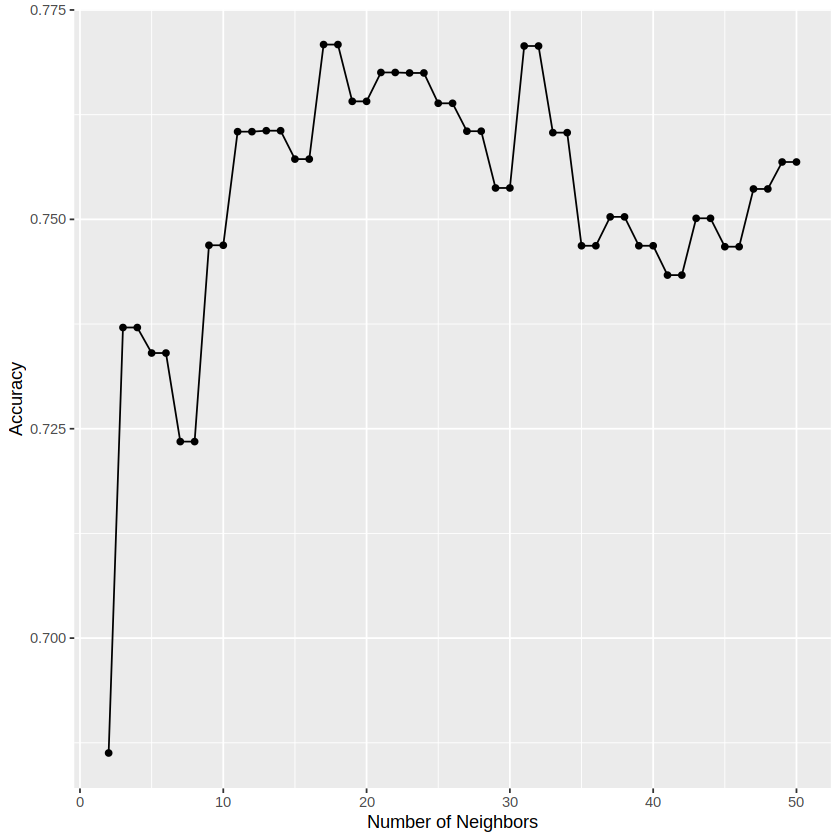

In [13]:
#finding k

knn_recipe <- recipe(Outcome~ ., data=training_filtered)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors=tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_vfold <- vfold_cv(training_filtered, v=5, strata = Outcome)

knn_workflow <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec)

k_vals <- tibble(neighbors = seq(from =2, to=50))
                 
knn_results <- knn_workflow |>
    tune_grid(resamples = knn_vfold, grid = k_vals) |>
    collect_metrics()
                 
accuracies <- knn_results |>
    filter(.metric =="accuracy")
                 
cross_val_plot <- ggplot(accuracies, aes(x=neighbors, y=mean)) +
    geom_point()+
    geom_line()+
    labs(x="Number of Neighbors", y="Accuracy")
cross_val_plot

Final k value chosen to be ??? 

In [21]:
#building the model

mnist_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |> #k value of 17 chosen for now, fix later?
    set_engine("kknn") |>
    set_mode("classification")

mnist_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(mnist_spec) |>
    fit(data=training_filtered)

#testing the model

mnist_predictions <- predict(mnist_fit, testing_filtered) |>
    bind_cols(testing_filtered)

mnist_metrics <- mnist_predictions |>
    metrics(truth=Outcome, estimate=.pred_class) |>
    filter(.metric =="accuracy")

mnist_conf_mat <- mnist_predictions |>
    conf_mat(truth=Outcome, estimate=.pred_class)

mnist_conf_mat

          Truth
Prediction  0  1
         0 58 19
         1  8 14

# Results

- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- creates a visualization of the analysis 
- note: all tables and figure should have a figure/table number and a legend

# Discussion

- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

# References

(APA style)

- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
- Make sure to cite the source of your data as well.